In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import datetime

from dateutil.relativedelta import relativedelta
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, roc_curve, precision_recall_curve, auc, classification_report, confusion_matrix,  precision_recall_curve, average_precision_score

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import RandomOverSampler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.svm import SVC

import tensorflow as tf
from sklearn.utils import class_weight

from sklearn.cluster import KMeans

pd.options.display.max_columns = None

In [2]:
df_bf = pd.read_csv("train_bf.csv")         #BENEFICIRY DATA
df_op = pd.read_csv("train_op.csv")         #OUTPATIENT DATA
df_ip = pd.read_csv("train_ip.csv")         #INPATIENT DATA
df_train_result = pd.read_csv("train.csv")  #POTENTIAL FRAUD FLAG

In [3]:
#AVAILABLE COLUMNS FROM BENEFICIARY TABLE
df_bf.columns

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt'],
      dtype='object')

In [4]:
#MAKE SURE NO DUPLICATES ARE FOUND
len(df_bf), len(df_bf['BeneID'].unique())

(138556, 138556)

In [5]:
df_bf.head(3)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40


In [6]:
df_ip.head(3)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_op.head(3)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [8]:
#CORRECTING FORMAT OF BENEFICIARY DATA
df_bf['DOB'] = pd.to_datetime(df_bf['DOB'])

#DATA IS FROM CLAIMS ON YEAR 2009, SO AGE CALCULATED BASED ON THAT YEAR
# df_bf['Age'] = df_bf['DOB'].apply(lambda x: relativedelta(datetime.datetime(2009,12,31), x).years)

#ADDED IsAlive column, with 1 as still being alive
# df_bf['IsAlive'] = (pd.isna(df_bf['DOD'])).astype(int)

#ASSUMING 1 MEANS HAVING THAT CONDITION, TURNING VALUE 2 INTO 0
df_bf.loc[:,'ChronicCond_Alzheimer':'ChronicCond_stroke'] = df_bf.loc[:,'ChronicCond_Alzheimer':'ChronicCond_stroke'].replace(2, 0)
df_bf['RenalDiseaseIndicator'] = df_bf['RenalDiseaseIndicator'].replace('Y',1)

In [9]:
df_ip.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6'],
      dtype='object')

In [10]:
df_ip[['BeneID','ClaimID']].nunique(), len(df_ip)

(BeneID     31289
 ClaimID    40474
 dtype: int64,
 40474)

In [11]:
#CORRECTING FORMAT OF INPATIENT DATA
df_ip[['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']] = df_ip[['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']].apply(pd.to_datetime)
df_ip['AdmissionDuration'] = df_ip[['AdmissionDt', 'DischargeDt']].apply(lambda x: relativedelta(x['DischargeDt'], x['AdmissionDt']).days, axis=1)

#CORRECTING FORMAT of OUTPATIENT DATA
df_op[['ClaimStartDt', 'ClaimEndDt']] = df_op[['ClaimStartDt', 'ClaimEndDt']].apply(pd.to_datetime)
#ADMISSION DURATION SET TO 0 SINCE NOT BEING ADMITTED
df_op['AdmissionDuration'] = 0

#MERGE CLAIMS DATA INTO 1 (OUTPATIENT & INPATIENT CLAIMS)
df_claim = pd.concat([df_op, df_ip])

#MERGE WITH RESULTING POTENTIAL FRAUDSTER DATA
df_train_result['PotentialFraud'] = (df_train_result['PotentialFraud'] == 'Yes').astype(int)
df_claim = df_claim.merge(df_train_result, how='left', on='Provider')

#CALCULATING DURATION OF EACH CLAIM
df_claim['ClaimDuration'] = df_claim[['ClaimStartDt', 'ClaimEndDt']].apply(lambda x: relativedelta(x['ClaimEndDt'], x['ClaimStartDt']).days, axis = 1)

In [12]:
df_claim.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode', 'AdmissionDuration', 'AdmissionDt',
       'DischargeDt', 'DiagnosisGroupCode', 'PotentialFraud', 'ClaimDuration'],
      dtype='object')

In [13]:
def calc_total(x):
    total = 0
    for each in x:
        if pd.notna(each):
            total = total + 1

    return total

In [14]:
#TOTALLING NUMBER OF DIAGNOSIS, PHYSICIANS VISITED, AND PROCEDURES PER CLAIM
df_claim['TotalDiag'] = df_claim.loc[:, 'ClmDiagnosisCode_1':'ClmDiagnosisCode_10'].apply(calc_total, axis = 1)
df_claim['TotalPhy'] = df_claim.loc[:, 'AttendingPhysician':'OtherPhysician'].apply(calc_total, axis = 1)
df_claim['TotalProc'] = df_claim.loc[:, 'ClmProcedureCode_1':'ClmProcedureCode_6'].apply(calc_total, axis = 1)

#CALCULATE TOTAL NUMBER OF CHRONIC CONDITION THE BENEFICIARY HAD
df_bf['TotalChronic'] = df_bf.loc[:, 'ChronicCond_Alzheimer': 'ChronicCond_stroke'].sum(axis=1)

#MERGING PATIENT DATA WITH THE CLAIMS
df_claim_merged = df_claim.merge(df_bf, how='left', on='BeneID')

#CALCULATE AGE OF PATIENT WHEN CLAIM WAS LODGED
df_claim_merged['Age'] = df_claim_merged.apply(lambda x: int((x['ClaimStartDt'] - x['DOB']).days/365), axis = 1)

#CHECK IF THE BENEFICIARY WAS ALIVE WHEN CLAIM WAS MADE
df_claim_merged['DOD'] = pd.to_datetime(df_claim_merged['DOD'])
df_claim_merged['isAlive'] = df_claim_merged[pd.notna(df_claim_merged['DOD'])].apply(lambda x: 1 if x['ClaimStartDt'] < x['DOD'] else 0, axis=1)
df_claim_merged['isAlive'] = df_claim_merged['isAlive'].fillna(1)

# LOOKING FOR POTENTIAL FEATURES

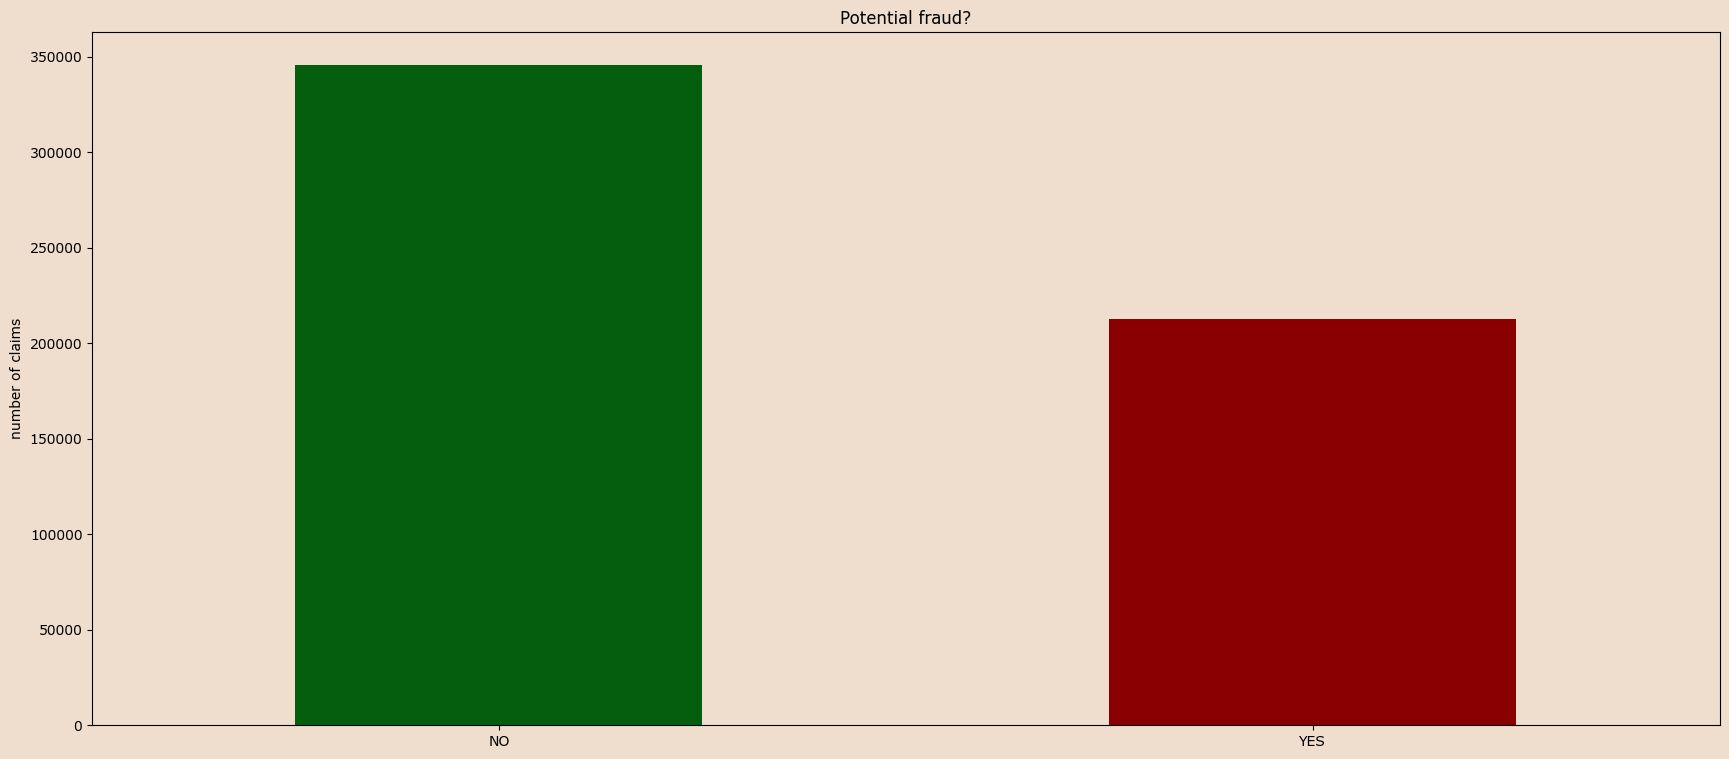

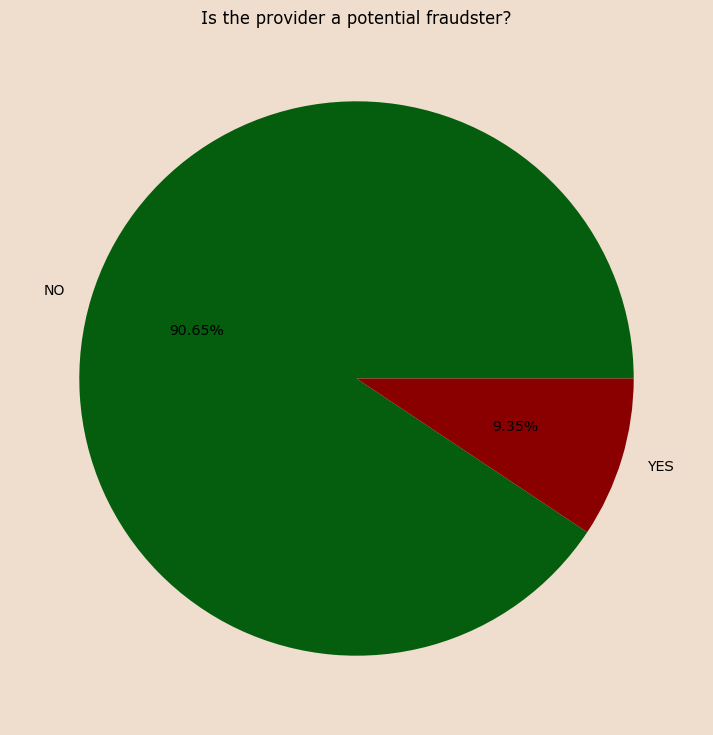

In [15]:
green = '#045E0E'
red = '#8A0000'
cola = "#efdecd"

#CHECK THE PROPORTION OF POTENTIAL FRAUDULENT CLAIMS
plt.figure(figsize=(21,9), facecolor=cola)
plt.axes().set_facecolor(cola)
df_claim[('PotentialFraud')].value_counts().plot(kind='bar', rot=0, color=[green, red])
plt.xticks([0,1], labels=['NO', 'YES'])
plt.title('Potential fraud?')
plt.ylabel('number of claims')
plt.show()

#CHECK THE PROPORTION OF POTENTIAL FRAUDULENT PROVIDERS
plt.figure(figsize=(9,9), facecolor=cola)
plt.axes().set_facecolor(cola)
df_train_result.groupby('PotentialFraud').size().plot(kind='pie', colors = [green, red], labels=['NO', 'YES'], autopct='%.2f%%')
plt.title('Is the provider a potential fraudster?')
plt.show()

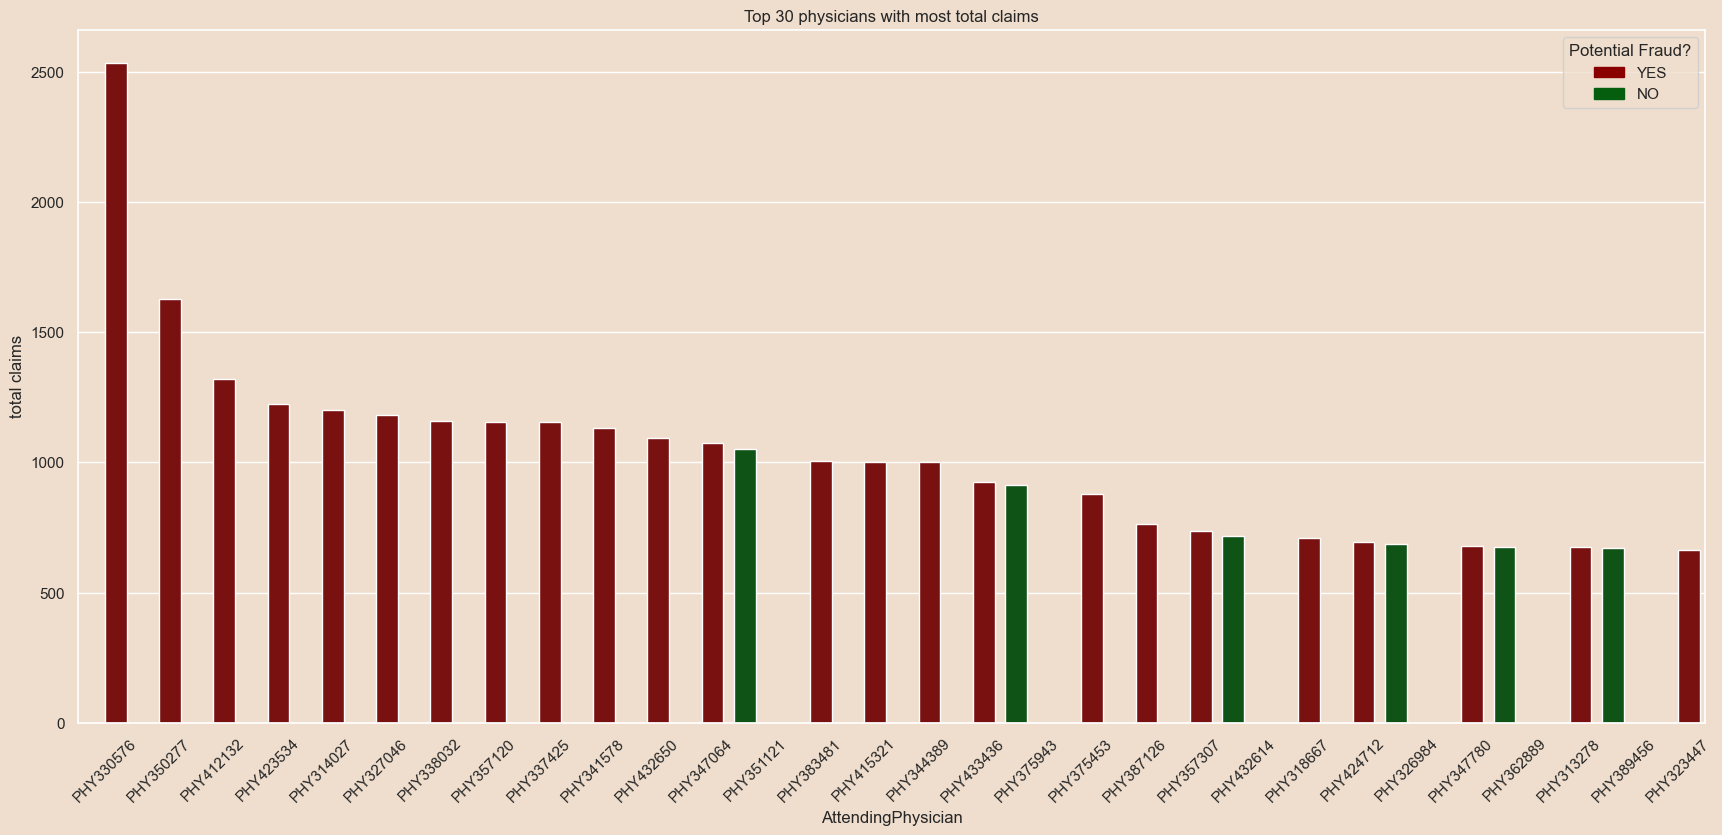

In [16]:
#CHECKING TO SEE IF ANY PARTICULAR PHYSICIANS HAVE MORE FRAUDULENT CLAIMS
phys_fraud_df = df_claim[['AttendingPhysician', 'PotentialFraud', 'ClaimID']].groupby(['AttendingPhysician', 'PotentialFraud']).count().sort_values('AttendingPhysician').reset_index()

sns.set(rc={"figure.figsize":(21, 9), 'axes.facecolor':cola, 'figure.facecolor':cola})
sns.barplot(data=phys_fraud_df.sort_values('ClaimID', ascending=False)[:30], 
            x='AttendingPhysician', y='ClaimID', 
            hue='PotentialFraud', 
            palette=[green,red])

red_patch = mpatches.Patch(color=red, label='YES')
green_patch = mpatches.Patch(color=green, label='NO')
plt.legend(title='Potential Fraud?', loc='upper right', handles=[red_patch, green_patch], facecolor=cola)


plt.xticks(rotation=45)
plt.ylabel('total claims')
plt.title('Top 30 physicians with most total claims')

plt.show()

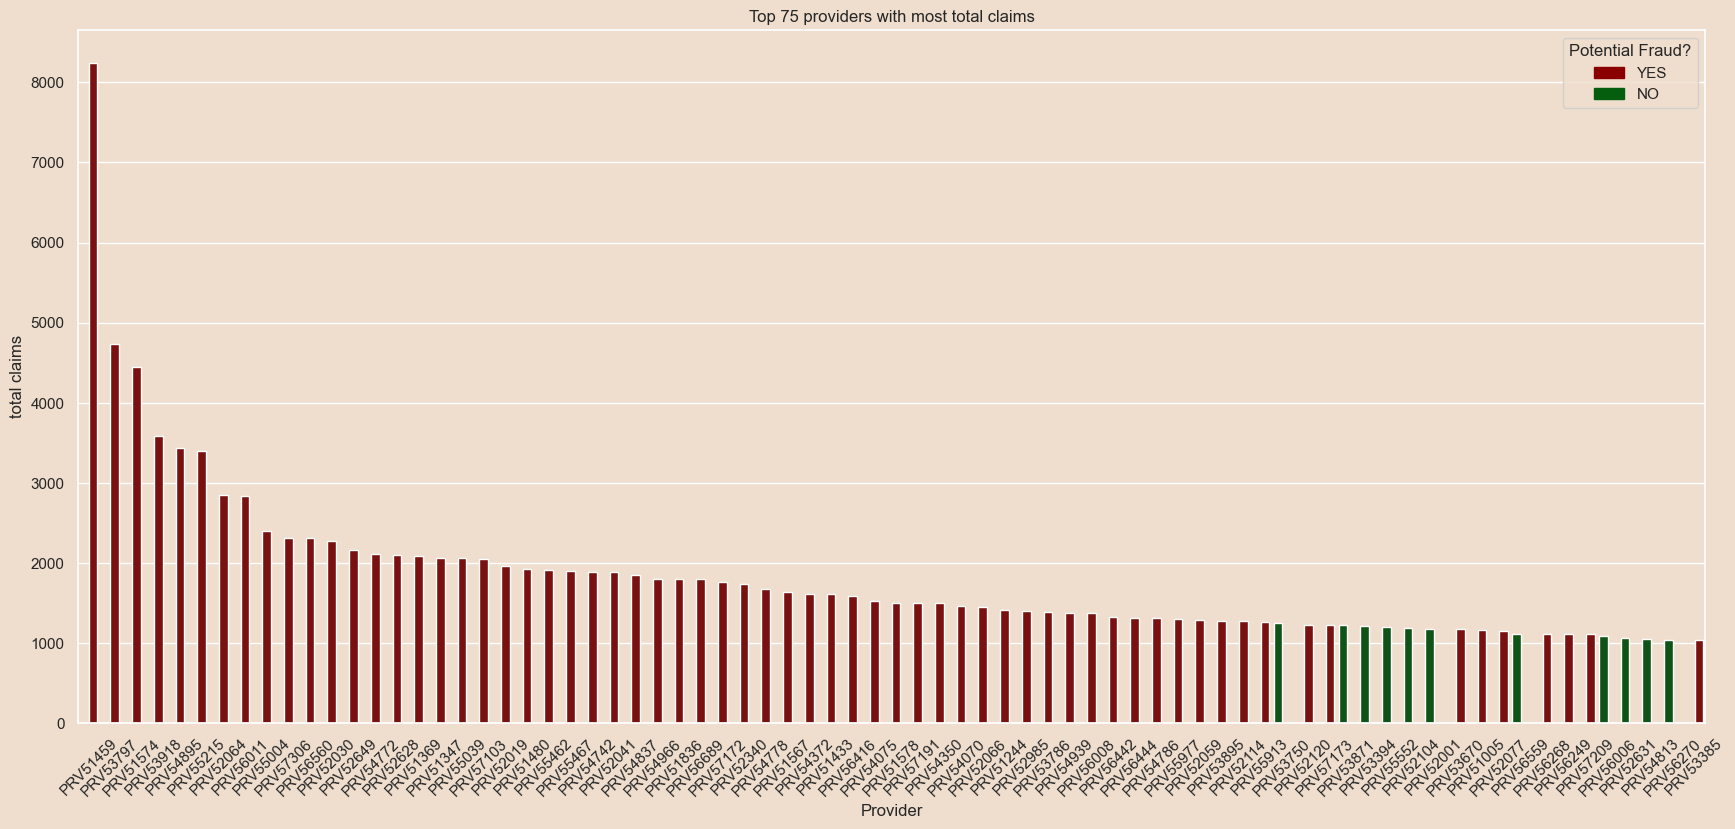

In [17]:
#CHECKING TO SEE THE NUMBER OF TOTAL CLAIMS MADE PER PROVIDER
prov_fraud_df = df_claim[['Provider', 'PotentialFraud', 'ClaimID']].groupby(['Provider', 'PotentialFraud']).count().sort_values('Provider').reset_index()

sns.set(rc={"figure.figsize":(21, 9), 'axes.facecolor':cola, 'figure.facecolor':cola})
sns.barplot(data=prov_fraud_df.sort_values('ClaimID', ascending=False)[:75], 
            x='Provider', y='ClaimID', 
            hue='PotentialFraud', 
            palette=[green, red])
plt.xticks(rotation=45)
plt.ylabel('total claims')
plt.title('Top 75 providers with most total claims')
plt.legend(title='Potential Fraud?', loc='upper right', handles=[red_patch, green_patch], facecolor=cola)

plt.show()

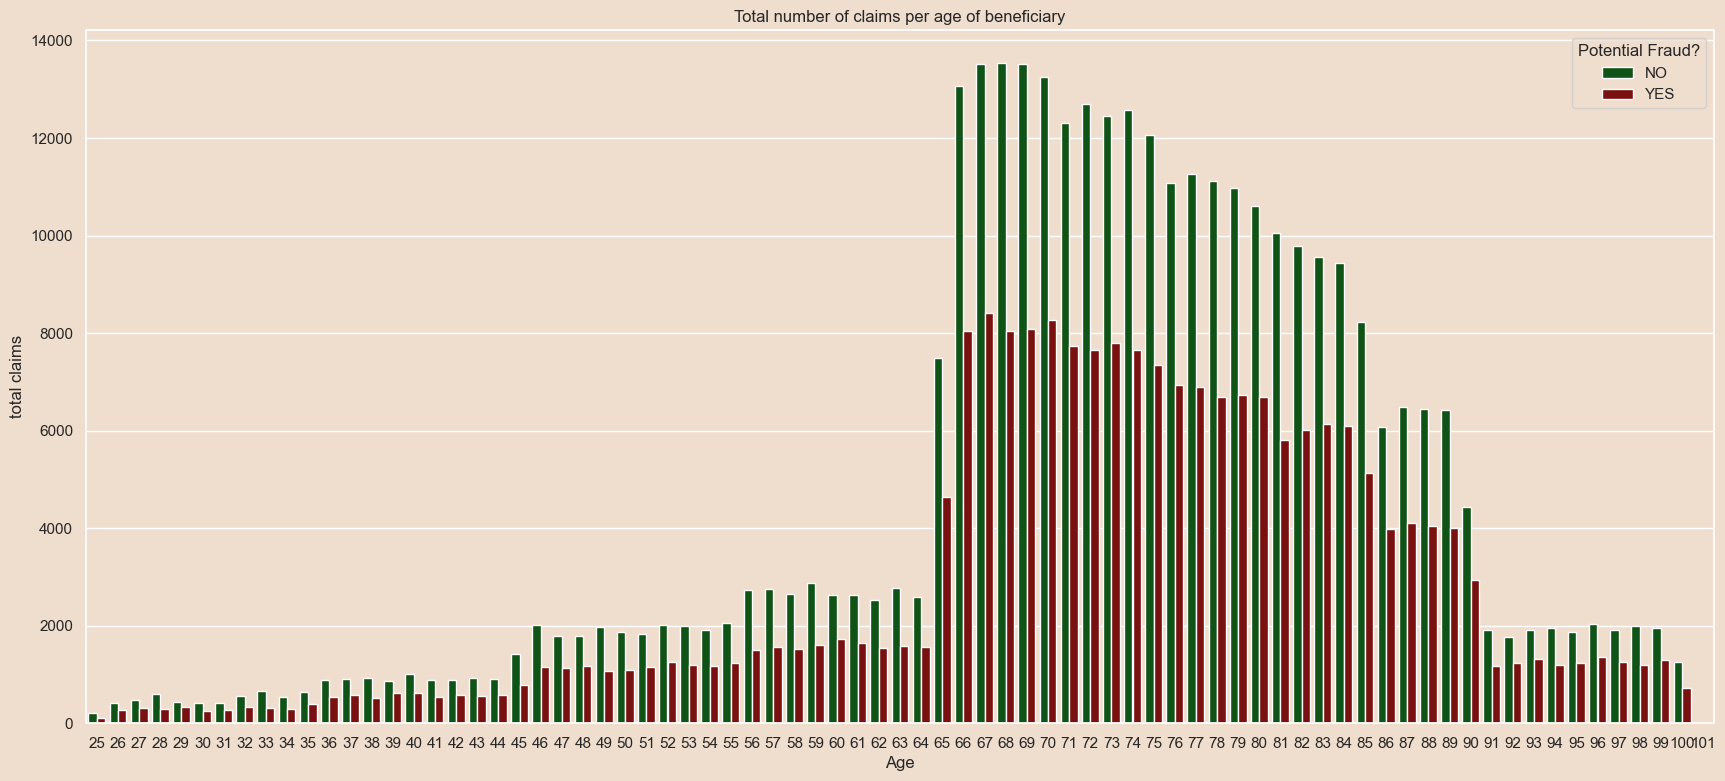

In [18]:
#CHECKING IF THERE IS A SIGNIFICANT DIFFERENCE ON AGE

sns.set(rc={'figure.figsize':(21,9), 'axes.facecolor':cola, 'figure.facecolor':cola})
sns.countplot(df_claim_merged, x='Age', hue='PotentialFraud',palette=[green, red])
plt.legend(labels = ['NO', 'YES'], facecolor=cola, title="Potential Fraud?")

plt.title('Total number of claims per age of beneficiary')
plt.ylabel('total claims')

plt.show()

In [19]:
#CHECKING THE DIFFERENCE ON WHETHER THE BENEFICIARY WAS STILL ALIVE
len(df_claim_merged[df_claim_merged['isAlive'] == 0])

19

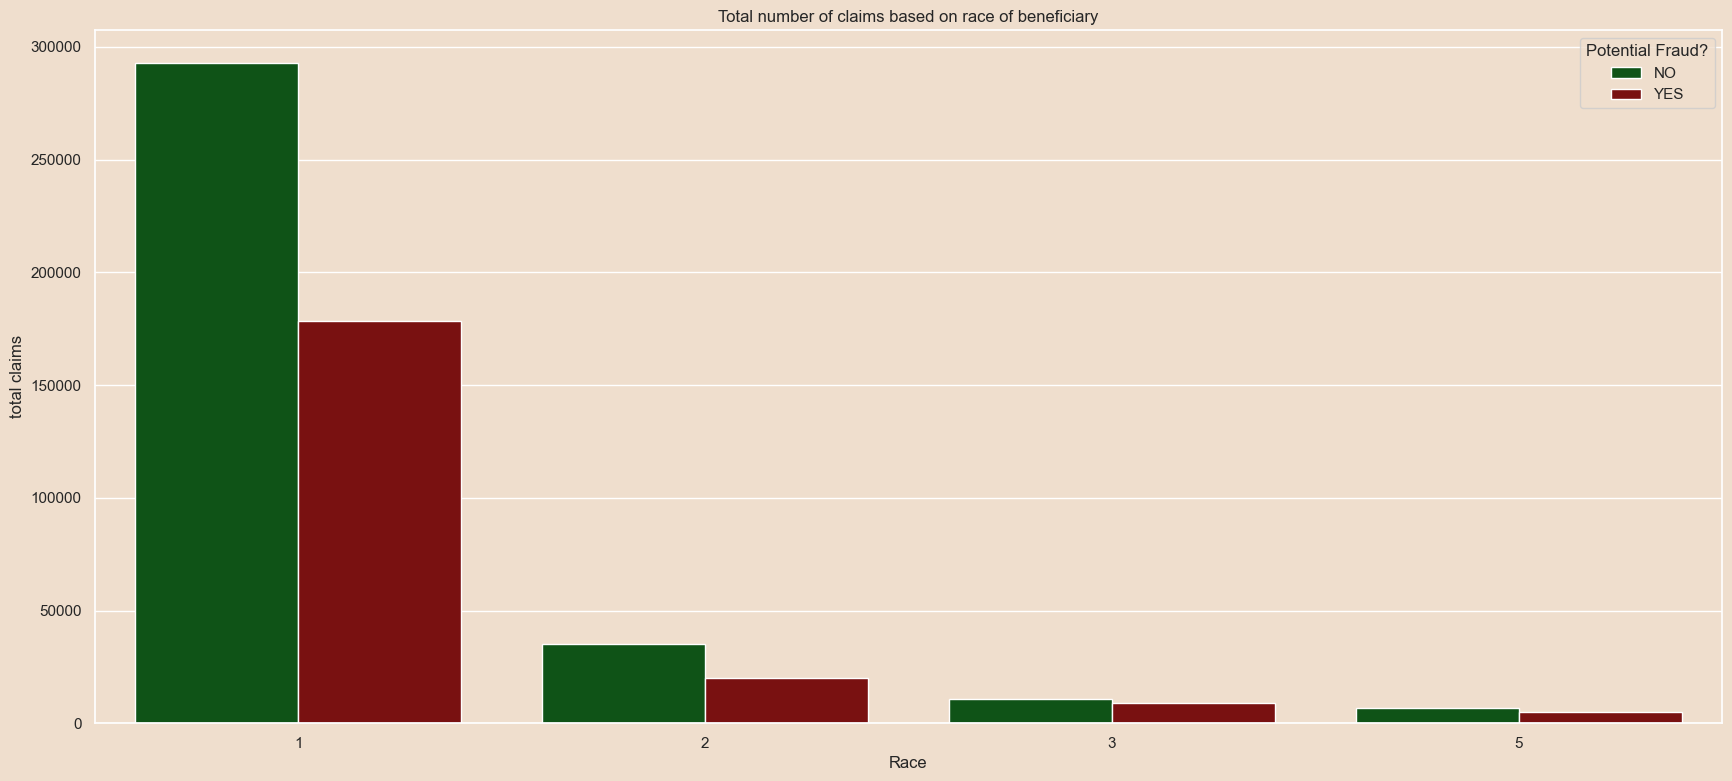

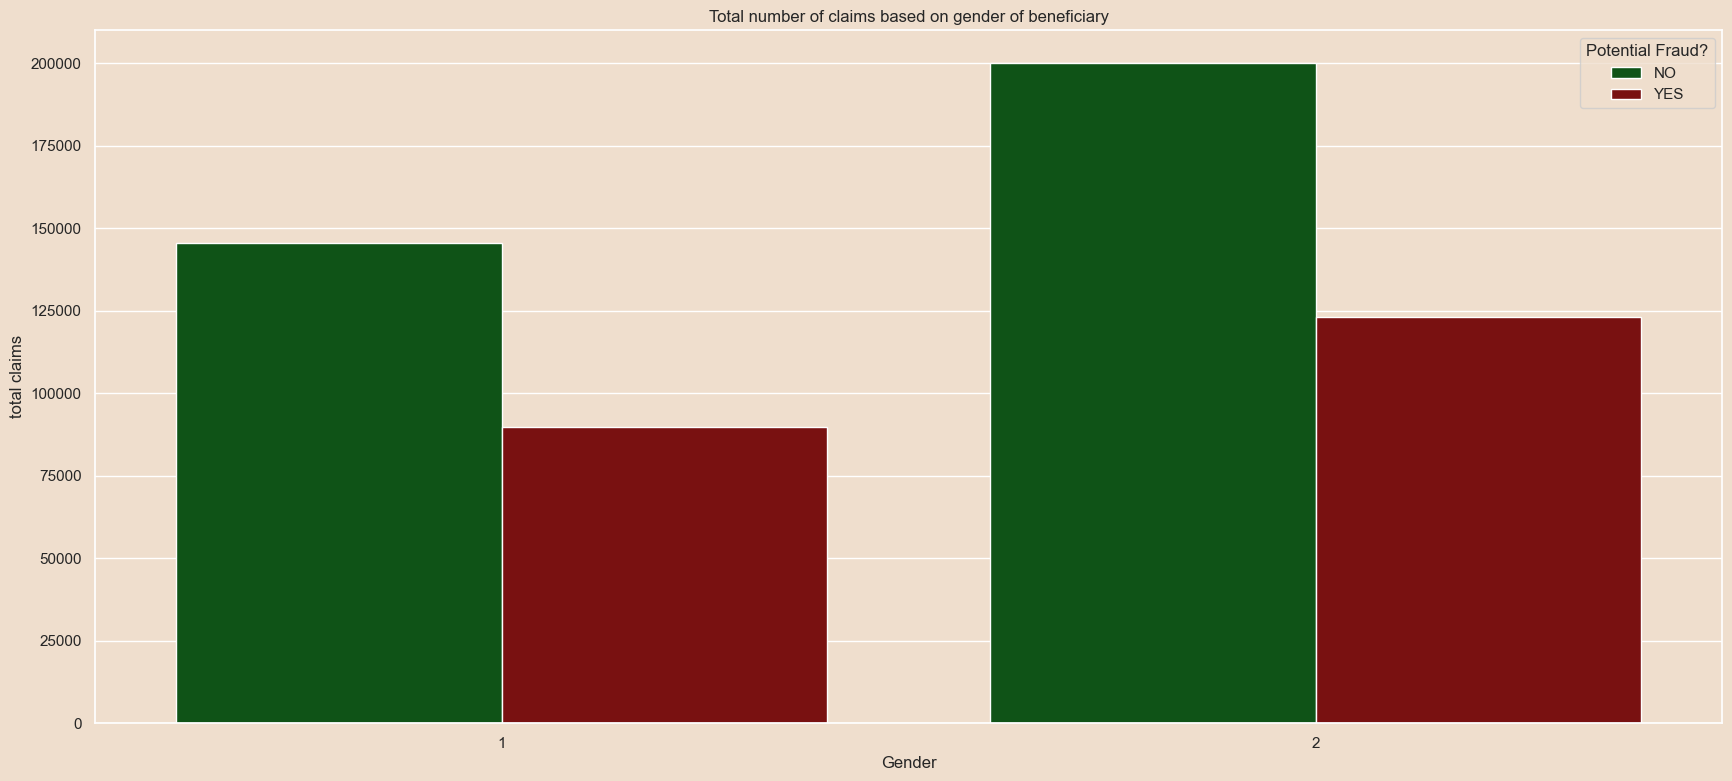

In [20]:
sns.set(rc={'figure.figsize':(21,9), 'axes.facecolor':cola, 'figure.facecolor':cola})
sns.countplot(df_claim_merged, x='Race', hue='PotentialFraud',palette=[green, red])
plt.legend(labels = ['NO', 'YES'], facecolor=cola, title="Potential Fraud?")

plt.title('Total number of claims based on race of beneficiary')
plt.ylabel('total claims')

plt.show()

sns.countplot(df_claim_merged, x='Gender', hue='PotentialFraud',palette=[green, red])
plt.legend(labels = ['NO', 'YES'], facecolor=cola, title="Potential Fraud?")

plt.title('Total number of claims based on gender of beneficiary')
plt.ylabel('total claims')

plt.show()

# PREPARING DATAFRAME

In [21]:
_COL_TO_DROP = [
                'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'PotentialFraud',
                'AttendingPhysician', 'OperatingPhysician', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
                'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
                'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
                'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
                'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
                'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
                'ClmProcedureCode_5', 'ClmProcedureCode_6', 'AdmissionDt',
                'DischargeDt', 'DOB', 'DOD', 'State', 'County'
               ]

In [29]:
#SUM OF EACH COLUMN
# df_sum = df_claim_merged.groupby(['Provider'], as_index = False)[['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 
#                                                   'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
#                                                   'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 
#                                                   'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
#                                                   'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 
#                                                   'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'
#                                                 #   ,'IsAlive', 'TotalPhy', 
#                                                 #   'TotalProc', 'AdmissionDuration', 'ClaimDuration'
#                                                   ]].sum()

#COUNT NUMBER SUBMISSIONS AND BENEFICIARIES
df_total = df_claim_merged[['BeneID', 'ClaimID']].groupby(df_claim_merged['Provider']).nunique().reset_index()

#CALCULATE MEAN
df_mean = df_claim_merged.groupby(['Provider'], as_index = False)[['NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
                                                                'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                                                                'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'TotalChronic', 'Age',
                                                                'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 
                                                                'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
                                                                'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 
                                                                'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                                                                'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 
                                                                'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                                'ChronicCond_stroke', 'TotalPhy',
                                                                'TotalProc', 'AdmissionDuration', 'ClaimDuration']].mean()

C:\Users\Hush\AppData\Local\Temp\ipykernel_17732\1144126521.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  'TotalProc', 'AdmissionDuration', 'ClaimDuration']].mean()


In [30]:
df_merged = df_total.merge(df_mean, on='Provider', how='left').merge(df_train_result, how='left', on='Provider').rename(columns={'BeneID': 'TotalBene', 'ClaimID': 'TotalClaims'})

y = df_merged['PotentialFraud']
X = df_merged.drop(columns=['PotentialFraud', 'Provider'])
# X = df_merged.drop(columns = _COL_TO_DROP)

#FILLING NULL VALUES IN DEDUCTIBLE AMOUNT TO 0
X.fillna(0, inplace=True)

In [31]:
#SPLITTING TESTING AND TRAINING DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69420)

#APPLY StandardScaller SINCE THERE IS MONETARY VALUE INVOVLED ALONG WITH CLASSIFIED VALUES
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

<AxesSubplot: >

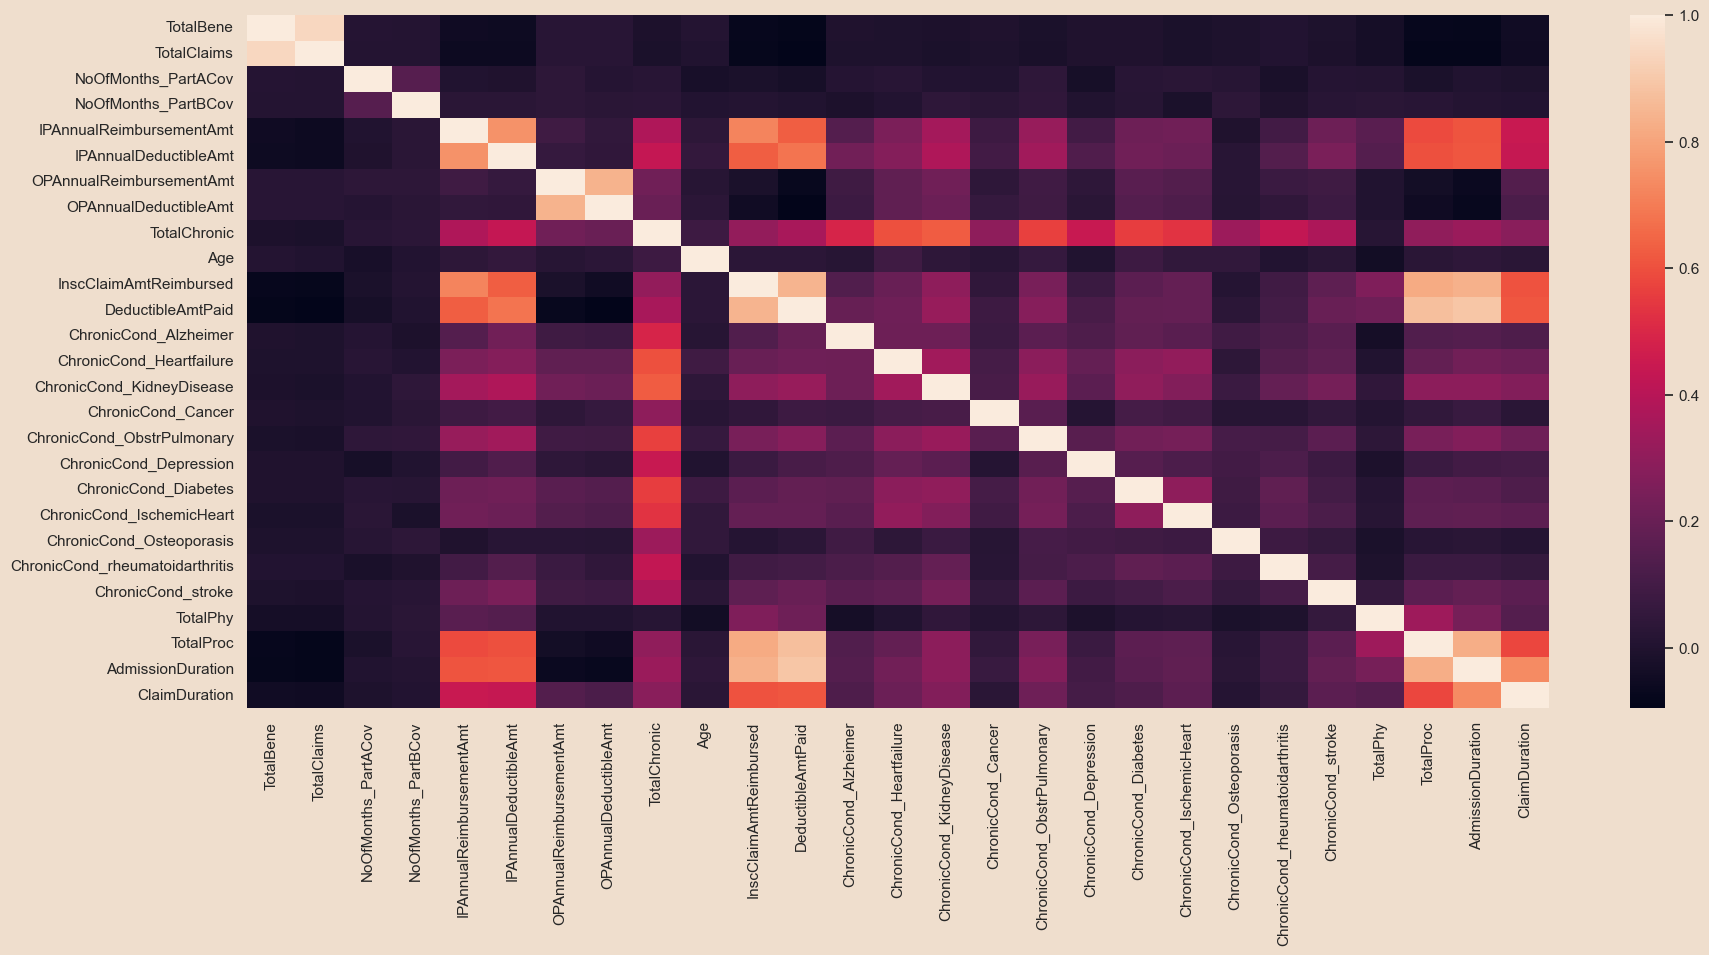

In [145]:
sns.set(rc={'axes.facecolor':cola, 'figure.facecolor':cola})
sns.heatmap(X.corr())

In [34]:
#FUNCTION TO APPLY GRID SEARCH WITH THE DESIRED SCORING
def grid(method, parameters, score):
    return GridSearchCV(method, 
                   param_grid = parameters, 
                   scoring=make_scorer(score),       
                   cv=5, n_jobs = -1)

In [35]:
def _plots(model):
    # predict probabilities
    probs = model.predict_proba(X_test)
    preds = probs[:,1]

    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, preds)
    pr_auc = average_precision_score(y_test, preds)

    # plot subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # ROC Curve subplot
    ax1.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax1.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic')
    ax1.legend(loc="lower right")

    # Precision-Recall Curve subplot
    ax2.plot(recall, precision, color='blue', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
    ax2.set_xlim([-0.05, 1.05])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall curve')
    ax2.legend(loc="lower right")

    plt.show()

## LOGISTIC REGRESSION

In [153]:
parameters = { 
        'C' : np.linspace(0.001, 1.0, 50)
}

lg_model = grid(LogisticRegression(max_iter=1000, class_weight='balanced'), parameters, recall_score)

lg_model.fit(X_train, y_train)

print("Tuned Hyperparameters :", lg_model.best_params_)
print("Recall :", lg_model.best_score_)

Tuned Hyperparameters : {'C': 0.12332653061224491}
Recall : 0.7340258958145136


In [154]:
y_pred = lg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       982
           1       0.34      0.72      0.46       100

    accuracy                           0.85      1082
   macro avg       0.65      0.79      0.69      1082
weighted avg       0.91      0.85      0.87      1082



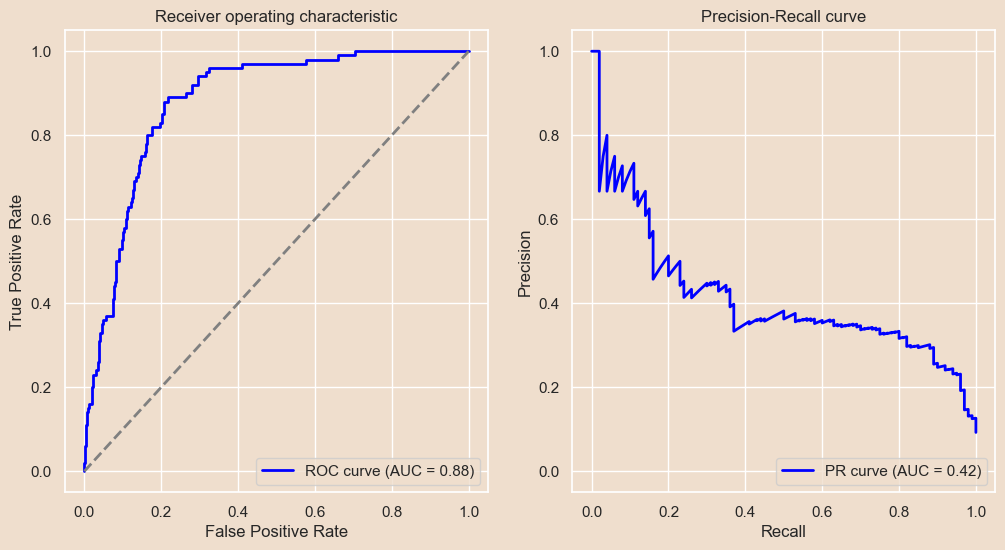

In [155]:
_plots(lg_model)

# SVM

In [156]:
parameters = { 
        #'gamma' : np.linspace(0.01, .1, 5),
        'C' : np.linspace(0.1, 1.0, 50)
}

svnm_model = grid(SVC(class_weight= 'balanced', probability=True), parameters, recall_score)
svnm_model.fit(X_train, y_train)

print("Tuned Hyperparameters :", svnm_model.best_params_)
print("Recall :",svnm_model.best_score_)

Tuned Hyperparameters : {'C': 0.2653061224489796}
Recall : 0.8497741644083108


In [157]:
y_pred = svnm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       982
           1       0.37      0.86      0.52       100

    accuracy                           0.85      1082
   macro avg       0.68      0.86      0.72      1082
weighted avg       0.93      0.85      0.88      1082



In [158]:
parameters = { 
        #'gamma' : np.linspace(0.01, .1, 5),
        'C' : np.linspace(0.1, 1.0, 50)
}

svnm_model_f1 = grid(SVC(class_weight= 'balanced', probability=True), parameters, f1_score)
svnm_model_f1.fit(X_train, y_train)

print("Tuned Hyperparameters :", svnm_model_f1.best_params_)
print("f1 :",svnm_model_f1.best_score_)

Tuned Hyperparameters : {'C': 0.2653061224489796}
f1 : 0.8497741644083108


In [159]:
y_pred = svnm_model_f1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       982
           1       0.37      0.86      0.52       100

    accuracy                           0.85      1082
   macro avg       0.68      0.86      0.72      1082
weighted avg       0.93      0.85      0.88      1082



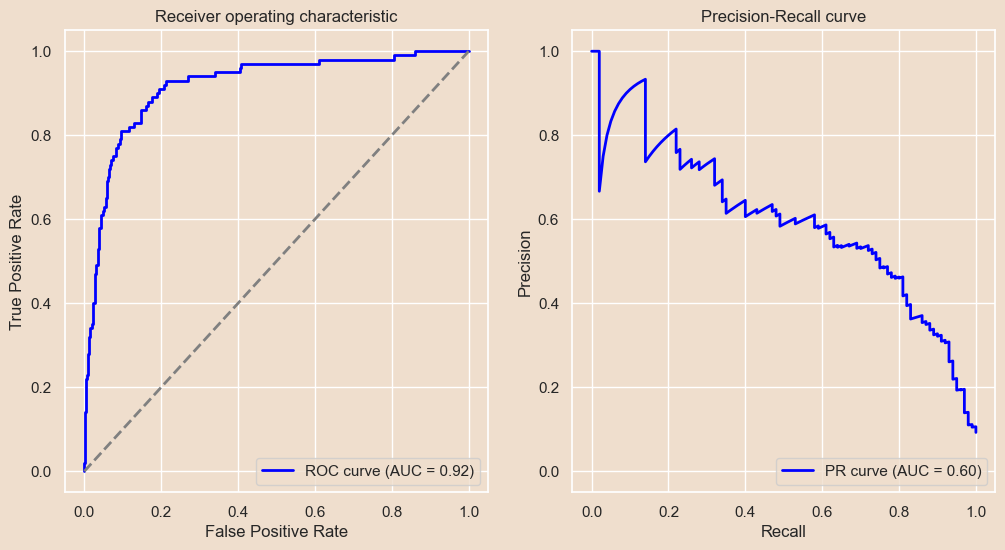

In [160]:
_plots(svnm_model_f1)

# RANDOM FOREST CLASSIFIER

In [161]:
parameters = {
    'max_depth': [80, 90, 100],
    'min_samples_split': list(range(100, 1001, 100)),
    'n_estimators': [100, 200, 300, 500]
}

rf_model = grid(RandomForestClassifier(class_weight= 'balanced'), parameters, recall_score)
rf_model.fit(X_train, y_train)

print("Tuned Hyperparameters :", rf_model.best_params_)
print("Recall :",rf_model.best_score_)

Tuned Hyperparameters : {'max_depth': 100, 'min_samples_split': 900, 'n_estimators': 200}
Recall : 0.926076482987052


In [162]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.19      0.97      0.32       100

    accuracy                           0.63      1082
   macro avg       0.59      0.78      0.53      1082
weighted avg       0.92      0.63      0.70      1082



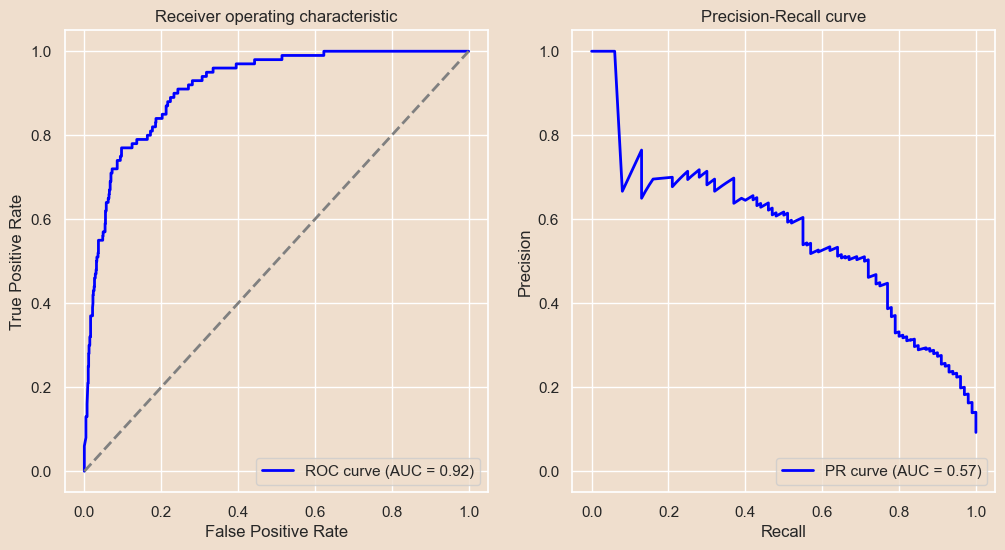

In [163]:
_plots(rf_model)

# REMOVING TOTAL COUNTS FROM THE TRAINING DATA

In [164]:
y2 = df_merged['PotentialFraud']
X2 = df_merged.drop(columns=['PotentialFraud', 'Provider', 'TotalClaims', 'TotalBene'])

#FILLING NULL VALUES IN DEDUCTIBLE AMOUNT TO 0
X2.fillna(0, inplace=True)
#SPLITTING TESTING AND TRAINING DATA
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=69420)

#APPLY StandardScaller SINCE THERE IS MONETARY VALUE INVOVLED ALONG WITH CLASSIFIED VALUES
X_train2 = StandardScaler().fit_transform(X_train2)
X_test2 = StandardScaler().fit_transform(X_test2)

<AxesSubplot: >

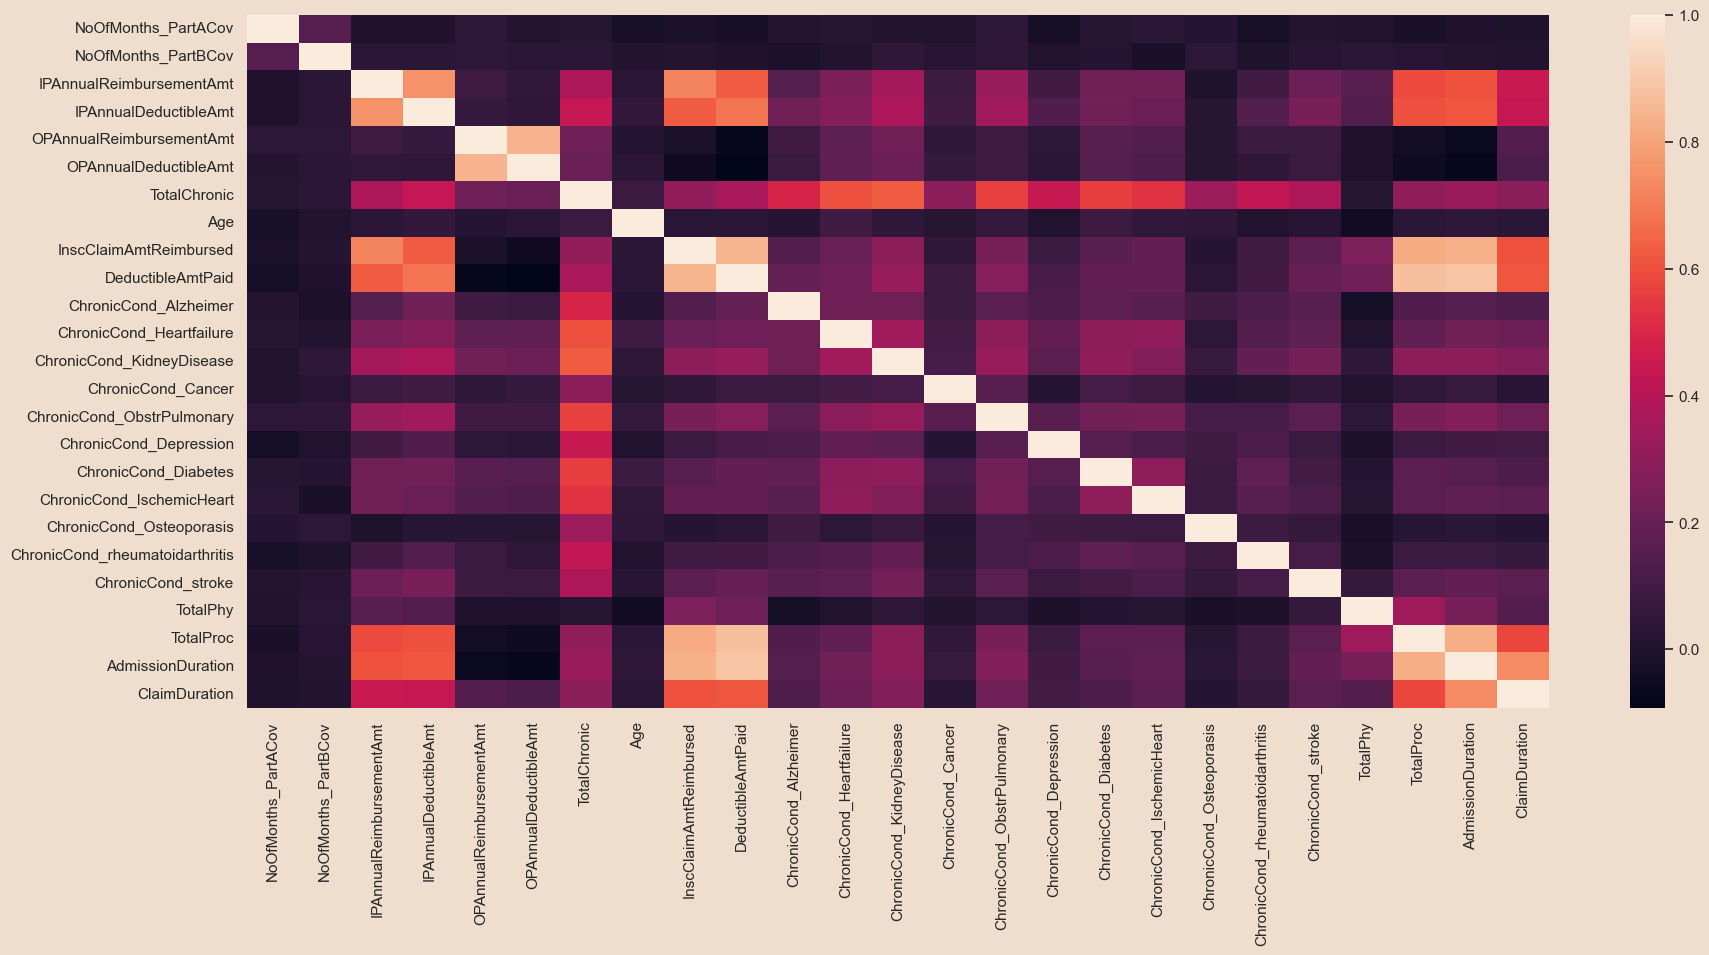

In [165]:
sns.set(rc={'axes.facecolor':cola, 'figure.facecolor':cola})
sns.heatmap(X2.corr())

# LOGISTIC REGRESSION

In [166]:
parameters = { 
        'C' : np.logspace(-2, 2, 25),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

lg_model2 = grid(LogisticRegression(max_iter=1000, class_weight='balanced'), parameters, recall_score)

lg_model2.fit(X_train2, y_train2)

print("Tuned Hyperparameters :", lg_model2.best_params_)
print("Recall :",lg_model2.best_score_)

Tuned Hyperparameters : {'C': 0.46415888336127775, 'solver': 'liblinear'}
Recall : 0.5146040349292382


In [167]:
y_pred = lg_model2.predict(X_test2)
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       982
           1       0.24      0.52      0.32       100

    accuracy                           0.80      1082
   macro avg       0.59      0.67      0.60      1082
weighted avg       0.88      0.80      0.83      1082



# SVM

In [168]:
parameters = { 
        #'gamma' : np.linspace(0.01, .1, 5),
        'C' : np.logspace(-2, 2, 10)
}

svnm_model2 = grid(SVC(class_weight= 'balanced', probability=True), parameters, recall_score)
svnm_model2.fit(X_train2, y_train2)

print("Tuned Hyperparameters :", svnm_model2.best_params_)
print("Recall :",svnm_model2.best_score_)

Tuned Hyperparameters : {'C': 1.6681005372000592}
Recall : 0.8152965974104186


In [169]:
y_pred = svnm_model2.predict(X_test2)
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       982
           1       0.29      0.81      0.43       100

    accuracy                           0.80      1082
   macro avg       0.64      0.81      0.66      1082
weighted avg       0.91      0.80      0.84      1082



In [170]:
parameters = { 
        #'gamma' : np.linspace(0.01, .1, 5),
        'C' : np.logspace(-2, 2, 10)
}

svnm_model3 = grid(SVC(class_weight= 'balanced', probability=True), parameters, f1_score)
svnm_model3.fit(X_train2, y_train2)

print("Tuned Hyperparameters :", svnm_model3.best_params_)
print("f1 :",svnm_model3.best_score_)

Tuned Hyperparameters : {'C': 1.6681005372000592}
f1 : 0.8152965974104186


In [171]:
y_pred = svnm_model3.predict(X_test2)
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88       982
           1       0.29      0.81      0.43       100

    accuracy                           0.80      1082
   macro avg       0.64      0.81      0.66      1082
weighted avg       0.91      0.80      0.84      1082



# RANDOM FOREST CLASSIFIER

In [172]:
parameters = {
    'max_depth': [80, 90, 100],
    'min_samples_split': list(range(100, 1001, 100)),
    'n_estimators': [100, 200, 300, 500]
}

rf_model2 = grid(RandomForestClassifier(class_weight= 'balanced'), parameters, recall_score)
rf_model2.fit(X_train2, y_train2)

print("Tuned Hyperparameters :", rf_model2.best_params_)
print("Recall :",rf_model2.best_score_)

Tuned Hyperparameters : {'max_depth': 80, 'min_samples_split': 1000, 'n_estimators': 100}
Recall : 0.8645287563986752


In [173]:
y_pred = rf_model2.predict(X_test2)
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.52      0.68       982
           1       0.17      0.98      0.29       100

    accuracy                           0.56      1082
   macro avg       0.58      0.75      0.49      1082
weighted avg       0.92      0.56      0.65      1082



In [174]:
parameters = {
    'max_depth': [80, 90, 100],
    'min_samples_split': list(range(10, 100, 100)),
    'n_estimators': [100, 200, 300, 500]
}

rf_model3 = grid(RandomForestClassifier(class_weight= 'balanced'), parameters, f1_score)
rf_model3.fit(X_train2, y_train2)

print("Tuned Hyperparameters :", rf_model3.best_params_)
print("f1 :",rf_model3.best_score_)

Tuned Hyperparameters : {'max_depth': 100, 'min_samples_split': 10, 'n_estimators': 100}
f1 : 0.42863595302619684


In [175]:
y_pred = rf_model3.predict(X_test2)
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       982
           1       0.69      0.45      0.55       100

    accuracy                           0.93      1082
   macro avg       0.82      0.71      0.75      1082
weighted avg       0.92      0.93      0.92      1082



In [176]:
parameters = {
    'max_depth': [80, 90, 100],
    'min_samples_split': list(range(2, 100, 100)),
    'n_estimators': [100, 200, 300, 500]
}

rf_model4 = GridSearchCV(RandomForestClassifier(class_weight= 'balanced'), param_grid = parameters, scoring='accuracy', cv=5, n_jobs = -1)
rf_model4.fit(X_train2, y_train2)

print("Tuned Hyperparameters :", rf_model4.best_params_)
print("accuracy :",rf_model4.best_score_)

Tuned Hyperparameters : {'max_depth': 100, 'min_samples_split': 2, 'n_estimators': 500}
accuracy : 0.9214428172849723


In [177]:
y_pred = rf_model4.predict(X_test2)
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       982
           1       0.74      0.29      0.42       100

    accuracy                           0.93      1082
   macro avg       0.84      0.64      0.69      1082
weighted avg       0.91      0.93      0.91      1082

